# Breast Cancer Classification: Benign vs. Malignant
**** 

<a id='TOC'></a>
1. **[Introduction](#Introduction)**
2. **[Data Overview](#Overview)<br>**
    a. [Loading Libraries & Data](#Loading)<br>
    b. [Data Cleaning](#Cleaning)<br>
3. **[Exploratory Data Analysis (EDA)](#EDA)<br>**
4. **[Classification Modelling](#Model)<br>**
    a. [Principal Component Analysis (PCA)](#PCA)<br>
    b. [Logistic Regression](#LogReg)<br>
    c. [Random Forest Classifier](#RandFor)<br>
    d. [Support-Vector Machine (SVM)](#SVM)<br>
    e. [k-Nearest Neighbours (kNN)](#kNN)
5. **[Conclusions](#Conclusions)<br>**
    a. [Summary](#Summary)<br>
    b. [Ethical Notes](#Ethics)<br>
    c. [Recommendations/Areas for Further Exploration](#Reco)
<br>
<br>
**Related: [Breast Cancer Dashboard](https://public.tableau.com/views/Breast_Cancer_Dashboard/BreastCancerDashboard?:language=en-US&:display_count=n&:origin=viz_share_link) on *Tableau Public* outlining the state of breast cancer in Canada in 2021**

<a id='Introduction'></a>
## 1. [Introduction](#Introduction)



<img src="benign_vs_malignant.png" width="450">

Source: Patel A. Benign vs Malignant Tumors. JAMA Oncol. 2020;6(9):1488. doi:10.1001/jamaoncol.2020.2592
**** 

This dataset, from the University of Wisconsin, contains 569 records of breast cancer tumours and their resulting diagnoses. Features of each tumour were computed from a digitized image of a fine needle aspirate (FNA) of a tumour in/around the breast.

Each record has an associated `id`, the corresponding `diagnosis`, and ten features computed for each cell nucleus. These ten features are: 

* `radius` (mean of distances from center to points on cell's perimeter)
* `texture` (standard deviation of gray-scale values)
* `perimeter`
* `area`
* `smoothness` (local variation in radius lengths)
* `compactness` (perimeter^2 / area - 1.0)
* `concavity` (severity of concave portions of the contour)
* `concave points` (number of concave portions of the contour)
* `symmetry`
* `fractal dimension`

The mean, standard error and "worst" or largest (i.e., mean of the three largest values) of these features were computed for each cell image, resulting in 30 features per record.

**** 

**The goal of this analysis** is to determine which features, of any, are most indicative of a benign/malignant tumour. Additionally, we will explore four machine learning models and their resulting accuracy scores in **classifying a tumour as benign or malignant** based on the corresponding feature measurements.

Accurate classification of a tumour is crucial in ensuring that the patient receives the care and supports that they need, physiologically, psychologically, and holistically. Thankfully, I can only imagine the wave of emotions that comes with a tumour diagnosis, but, presumably, the more accurate this classification can be, the steadier the ensuing wave (while still appreciating that this is a sizeable surge of sentiments).

[↑ Back to TOC](#TOC)

<a id='Overview'></a>
## 2. [Data Overview](#Overview)

<a id='Loading'></a>
### 2a. [Loading Libraries & Data](#Loading)

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm

# import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

# hyperparameter tuning
from itertools import product

# import evaluation functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

# matplotlib for plotting modification
import matplotlib
import matplotlib.pyplot as plt

# scikitplot to directly plot the results
import graphviz
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'b'

colors = ['xkcd:grey', 'xkcd:light purple', 'xkcd:light yellow','xkcd:light green']

In [3]:
df = pd.read_csv('breast_cancer_data.csv')
df.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


<a id='Cleaning'></a>
### 2b. [Data Cleaning](#Cleaning)

In [4]:
# viewing all columns for first (0th) record for a sample
df.iloc[0,:]

id                           842302
diagnosis                         M
radius_mean                   17.99
texture_mean                  10.38
perimeter_mean                122.8
area_mean                    1001.0
smoothness_mean              0.1184
compactness_mean             0.2776
concavity_mean               0.3001
concave points_mean          0.1471
symmetry_mean                0.2419
fractal_dimension_mean      0.07871
radius_se                     1.095
texture_se                   0.9053
perimeter_se                  8.589
area_se                       153.4
smoothness_se              0.006399
compactness_se              0.04904
concavity_se                0.05373
concave points_se           0.01587
symmetry_se                 0.03003
fractal_dimension_se       0.006193
radius_worst                  25.38
texture_worst                 17.33
perimeter_worst               184.6
area_worst                   2019.0
smoothness_worst             0.1622
compactness_worst           

`Unnamed: 32` looks to be blank for all records—we will drop it.

In [5]:
df.drop(columns=['id','Unnamed: 32'], inplace=True)

In [6]:
# checking for any NaN values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

No null values to worry about, which is great. Now, we will move onto a deeper look at the data.

[↑ Back to TOC](#TOC)

**** 
<a id='EDA'></a>
## 3. [Exploratory Data Analysis (EDA)](#EDA)

In [7]:
print(f"In total, the dataset contains {df.shape[0]} records, each with {df.shape[1]} features (including diagnosis), all of which are floats.")

In total, the dataset contains 569 records, each with 31 features (including diagnosis), all of which are floats.


In [8]:
# summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


In [9]:
# grouping by diagnosis, count of each
df.groupby('diagnosis').size()

diagnosis
B    357
M    212
dtype: int64

Text(0, 0.5, 'Diagnosis Count')

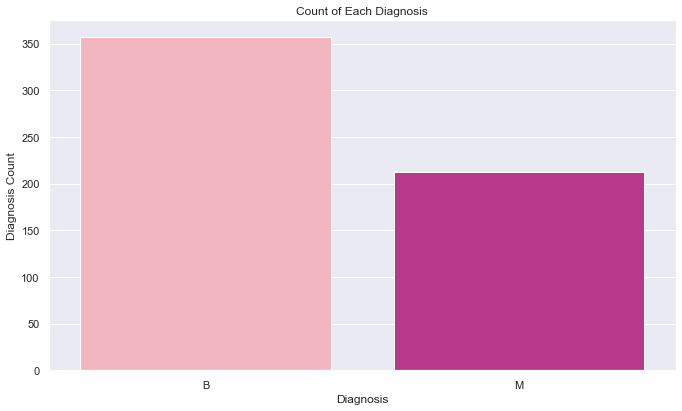

In [10]:
# df.groupby('diagnosis').size().plot(kind='bar')

sns.set(rc = {'figure.figsize':(10,6)})
ax = sns.countplot(x='diagnosis', data=df, order = df['diagnosis'].value_counts().index, palette='RdPu')
ax.set_title('Count of Each Diagnosis')
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Diagnosis Count')

We can see that this dataset contains 357 diagnoses of benign tumours and 212 diagnosis of malignant tumours (i.e., not a balanced dataset).

For modelling purposes, we will recast the diagnoses of "benign" and "malignant" as 0 and 1, respectively.

In [11]:
# recast "B" and "M" as diagnoses with 0 and 1
df['diagnosis'] = df['diagnosis'].replace(['B', 'M'], [0, 1])

pd.set_option('display.max_columns', None) # force viewing all columns, just to see
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We know that the `diagnosis` column will be our dependent variable, while all other features will be independent variables.

In [12]:
# splitting data into independent and dependent variables
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [13]:
X.shape

(569, 30)

Viewing the distribution of these features would prove helpful to see the significant differences between diagnoses. Rather than creating histograms for each, we will build violin plots, using subsets of the features for the sake of a simpler data visualization.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'perimeter_mean'),
  Text(3, 0, 'area_mean'),
  Text(4, 0, 'smoothness_mean'),
  Text(5, 0, 'compactness_mean'),
  Text(6, 0, 'concavity_mean'),
  Text(7, 0, 'concave points_mean'),
  Text(8, 0, 'symmetry_mean'),
  Text(9, 0, 'fractal_dimension_mean')])

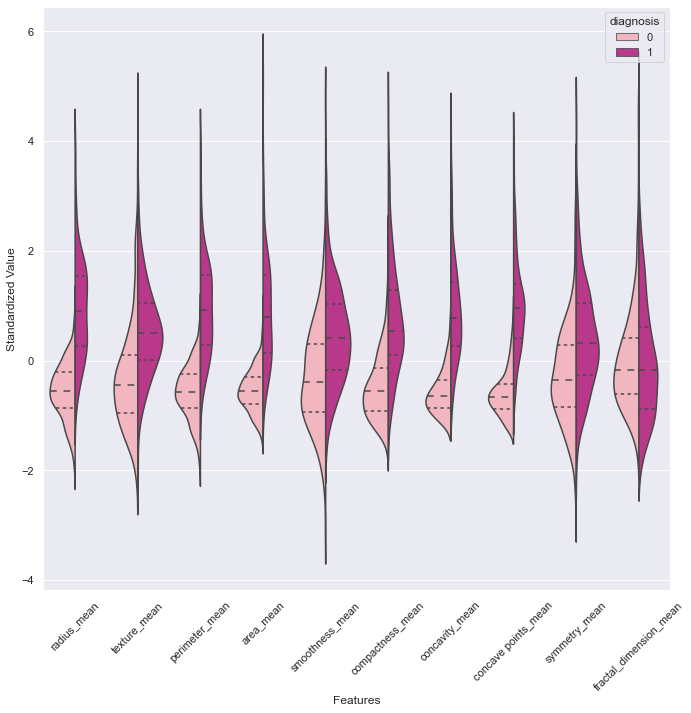

In [14]:
# first ten features
data = X
data_n_2 = (data - data.mean()) / (data.std()) # standardize values to put on same plot
data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars='diagnosis',
                    var_name='Features',
                    value_name='Standardized Value')
plt.figure(figsize=(10,10))
sns.violinplot(x='Features', y='Standardized Value', hue='diagnosis', palette='RdPu', data=data, split=True, inner='quart')
plt.xticks(rotation=45)

If the above "violins" have distinct separations between diagnoses within a given feature, that feature shows promise for classification. For example, `fractal_dimension_mean` shows little, if any, difference between benign and malignant tumours, whereas `radius_mean` exhibits a more prominent division between the two diagnoses. **Features that might lead to more accurate predictions are those that have a nontrivial difference in standardized distribution between diagnoses**.

Potential *mean* features of interest include `radius_mean`, `perimeter_mean`, `area_mean`, `concavity_mean`, and `concave points_mean`. 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'radius_se'),
  Text(1, 0, 'texture_se'),
  Text(2, 0, 'perimeter_se'),
  Text(3, 0, 'area_se'),
  Text(4, 0, 'smoothness_se'),
  Text(5, 0, 'compactness_se'),
  Text(6, 0, 'concavity_se'),
  Text(7, 0, 'concave points_se'),
  Text(8, 0, 'symmetry_se'),
  Text(9, 0, 'fractal_dimension_se')])

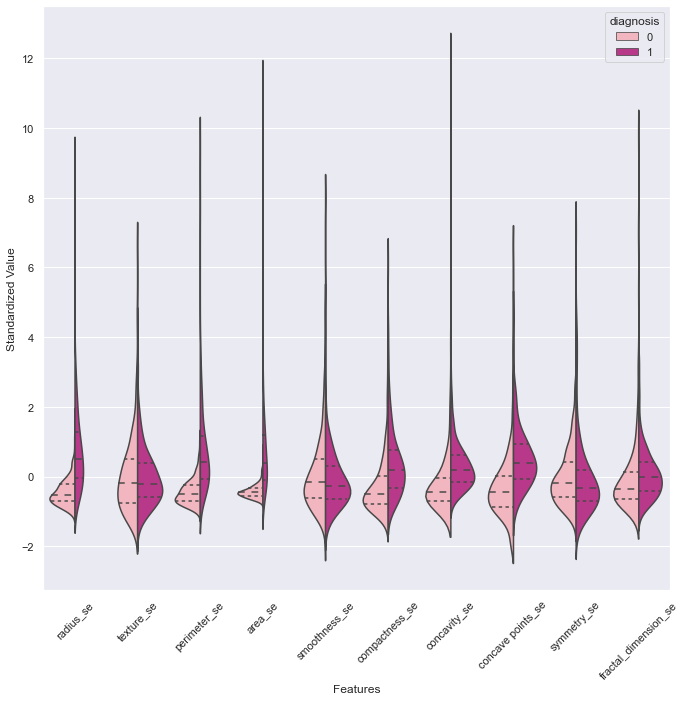

In [15]:
# second group of features
data = pd.concat([y,data_n_2.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars='diagnosis',
                    var_name='Features',
                    value_name='Standardized Value')
plt.figure(figsize=(10,10))
sns.violinplot(x='Features', y='Standardized Value', hue='diagnosis', palette='RdPu', data=data, split=True, inner='quart')
plt.xticks(rotation=45)

Potential *se* features of interest include `concavity_se`, and `concave points_se`, though these are not especially pronounced differences. The cluster of benign records of `area_se` is notably concentrated, too.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'radius_worst'),
  Text(1, 0, 'texture_worst'),
  Text(2, 0, 'perimeter_worst'),
  Text(3, 0, 'area_worst'),
  Text(4, 0, 'smoothness_worst'),
  Text(5, 0, 'compactness_worst'),
  Text(6, 0, 'concavity_worst'),
  Text(7, 0, 'concave points_worst'),
  Text(8, 0, 'symmetry_worst'),
  Text(9, 0, 'fractal_dimension_worst')])

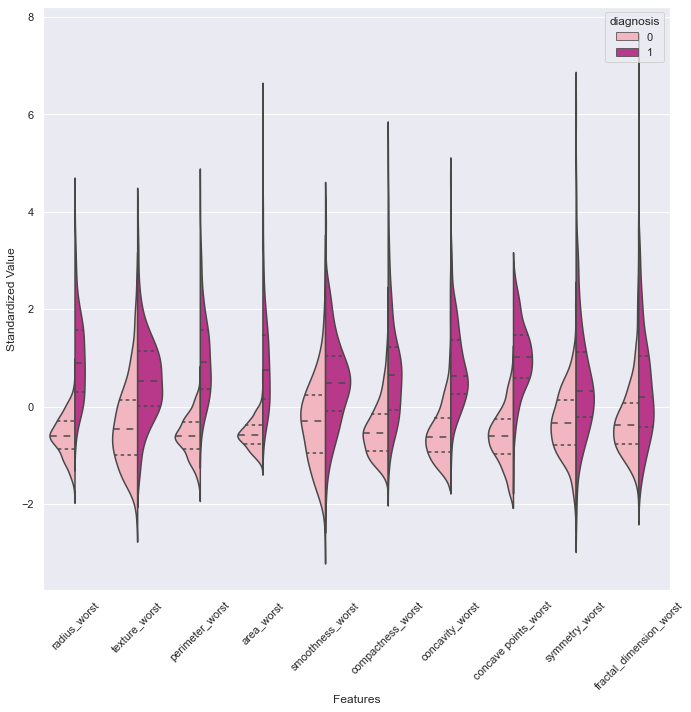

In [16]:
# third group of features
data = pd.concat([y,data_n_2.iloc[:,20:]],axis=1)
data = pd.melt(data,id_vars='diagnosis',
                    var_name='Features',
                    value_name='Standardized Value')
plt.figure(figsize=(10,10))
sns.violinplot(x='Features', y='Standardized Value', hue='diagnosis', palette='RdPu', data=data, split=True, inner='quart')
plt.xticks(rotation=45)

Finally, potential *worst* features of interest include `radius_worst`, `perimeter_worst`, `area_worst`, and `concave points_worst`.

It is worth nothing that the features of interest mentioned above likely have some degree of multicollinearity, especially with so many variables at play. As a result, if any two features (excluding `diagnosis`, of course) are highly correlated, we can safely use *one* of the two (or three) related features in the model and put the rest to the side, even for the sake of efficiency.

With the help of a heatmap, we will take a preliminary look at any particularly interesting correlations amongst feature measurements of each cell.

**** 
### Visualizing Correlation via Heatmap
Which specific measurements of a tumour are more closely correlated with resulting diagnosis (benign vs. malignant)?

<AxesSubplot:>

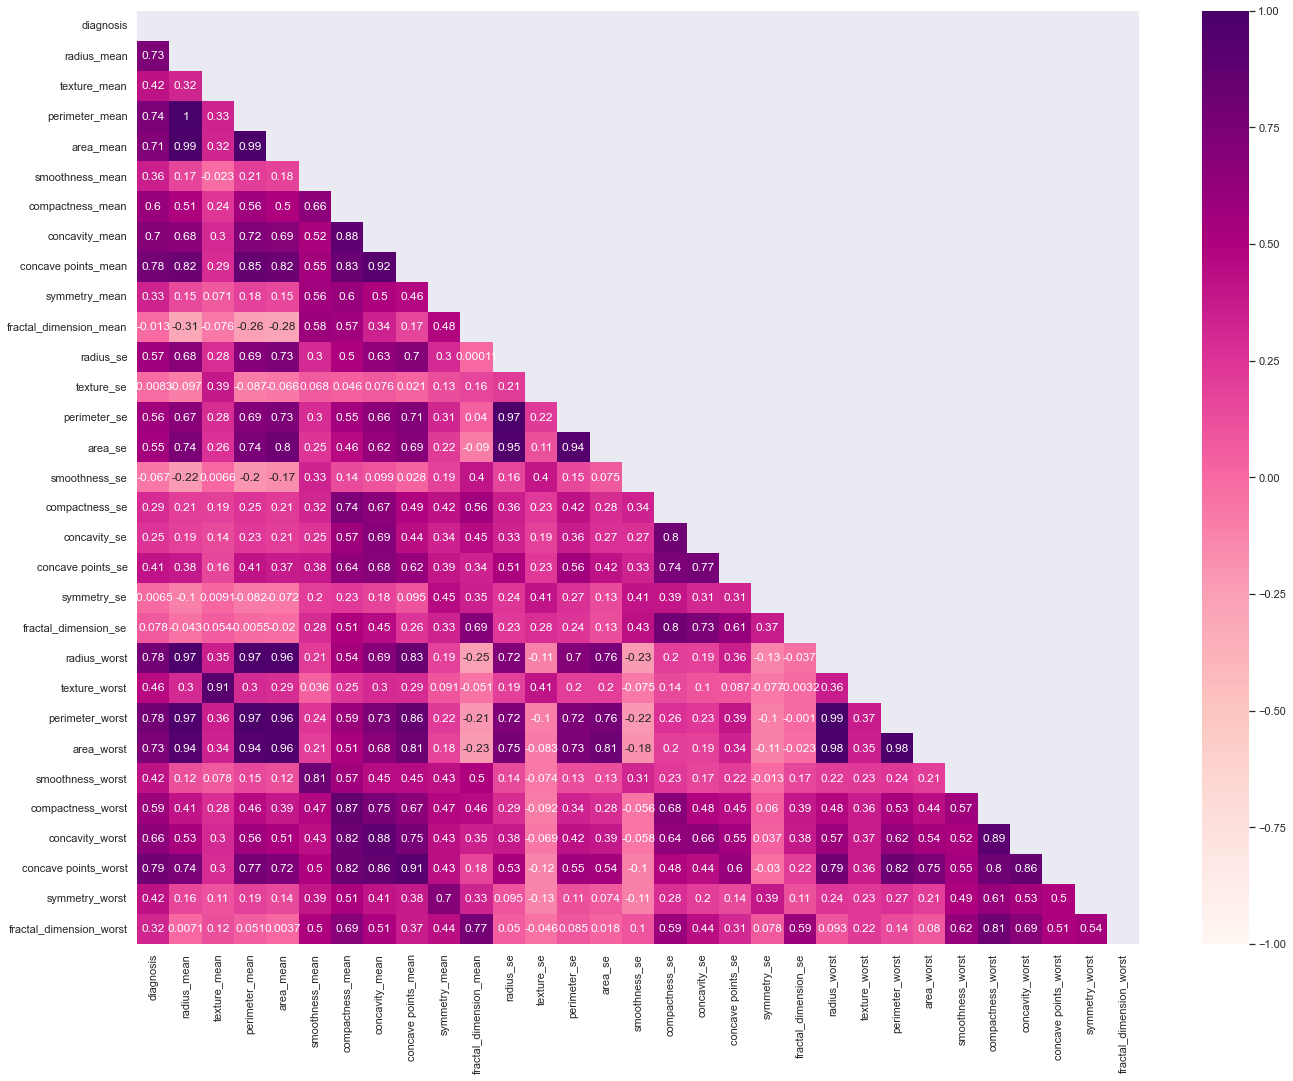

In [17]:
correlation = df.corr()
plt.figure(figsize=(20, 16))
matrix = np.triu(np.ones_like(df.corr())) # set a mask to only show lower half
sns.heatmap(correlation, mask=matrix, cmap='RdPu', vmin=-1, vmax=1, fmt='.2g', annot=True)

From the above heatmap, we can see the following strong correlations with `diagnosis`:
* `concave points_worst` (0.79);
* `perimeter_worst`, `radius_worst`, and `concave points_mean` (all 0.78);
* `perimeter_mean` (0.74);
* `area_worst` and `radius_mean` (0.73);
* `area_mean` (0.71); and
* `concavity_mean` (0.70)

Smaller heatmaps with fewer features should allow for a smaller-scale picture of multicollinearity.

In [18]:
# splitting the columns into three "categories" allows for more isolated processing and feature selection
features_mean = list(df.columns[1:11])
features_se = list(df.columns[11:20])
features_worst = list(df.columns[21:31])

<AxesSubplot:>

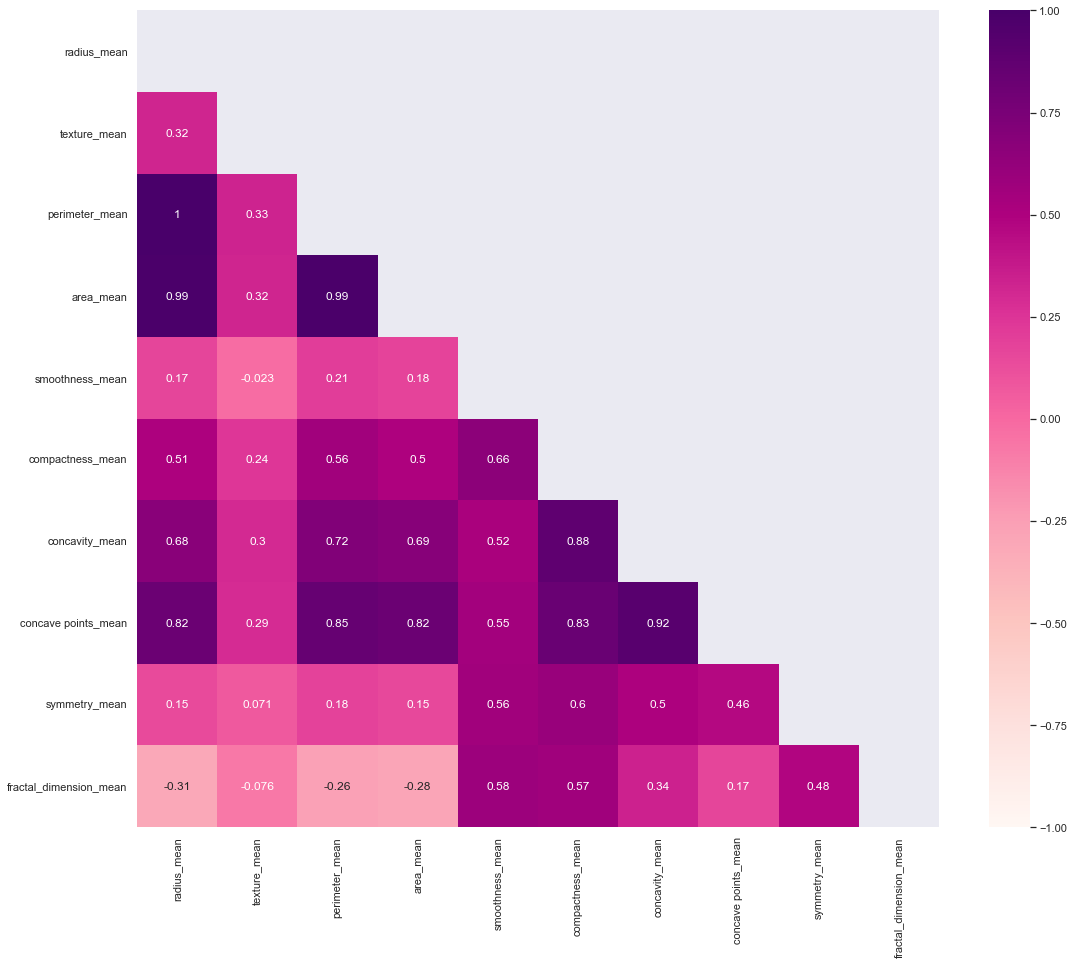

In [19]:
mean_corr = df[features_mean].corr()
plt.figure(figsize=(16, 14))
matrix = np.triu(np.ones_like(df[features_mean].corr())) # set a mask to only show lower half
sns.heatmap(mean_corr, mask=matrix, cmap='RdPu', vmin=-1, vmax=1, fmt='.2g', annot=True)

Based on the above, a model might only need *one of* `radius_mean`/`perimeter_mean`/`area_mean`.

Additionally, it might only need *one of* `concavity_mean`/`concave points_mean`.

<AxesSubplot:>

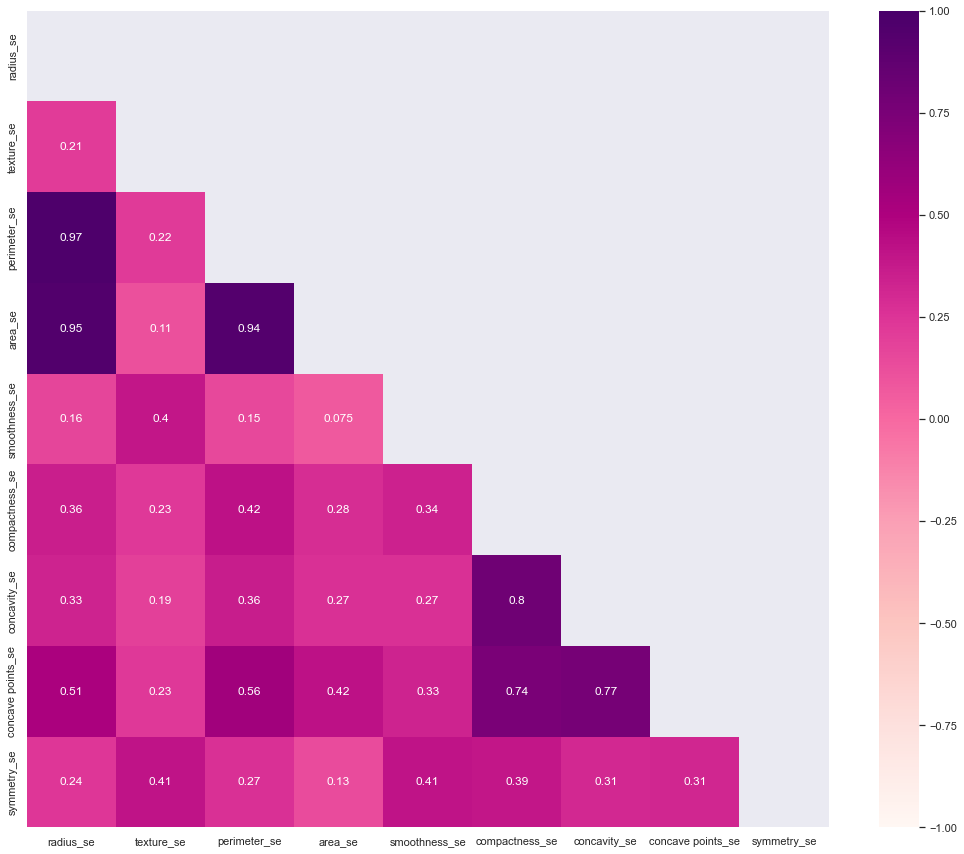

In [20]:
se_corr = df[features_se].corr()
plt.figure(figsize=(16, 14))
matrix = np.triu(np.ones_like(df[features_se].corr())) # set a mask to only show lower half
sns.heatmap(se_corr, mask=matrix, cmap='RdPu', vmin=-1, vmax=1, fmt='.2g', annot=True)

Similarly, a model might only need *one of* `radius_se`/`perimeter_se`/`area_se`.

<AxesSubplot:>

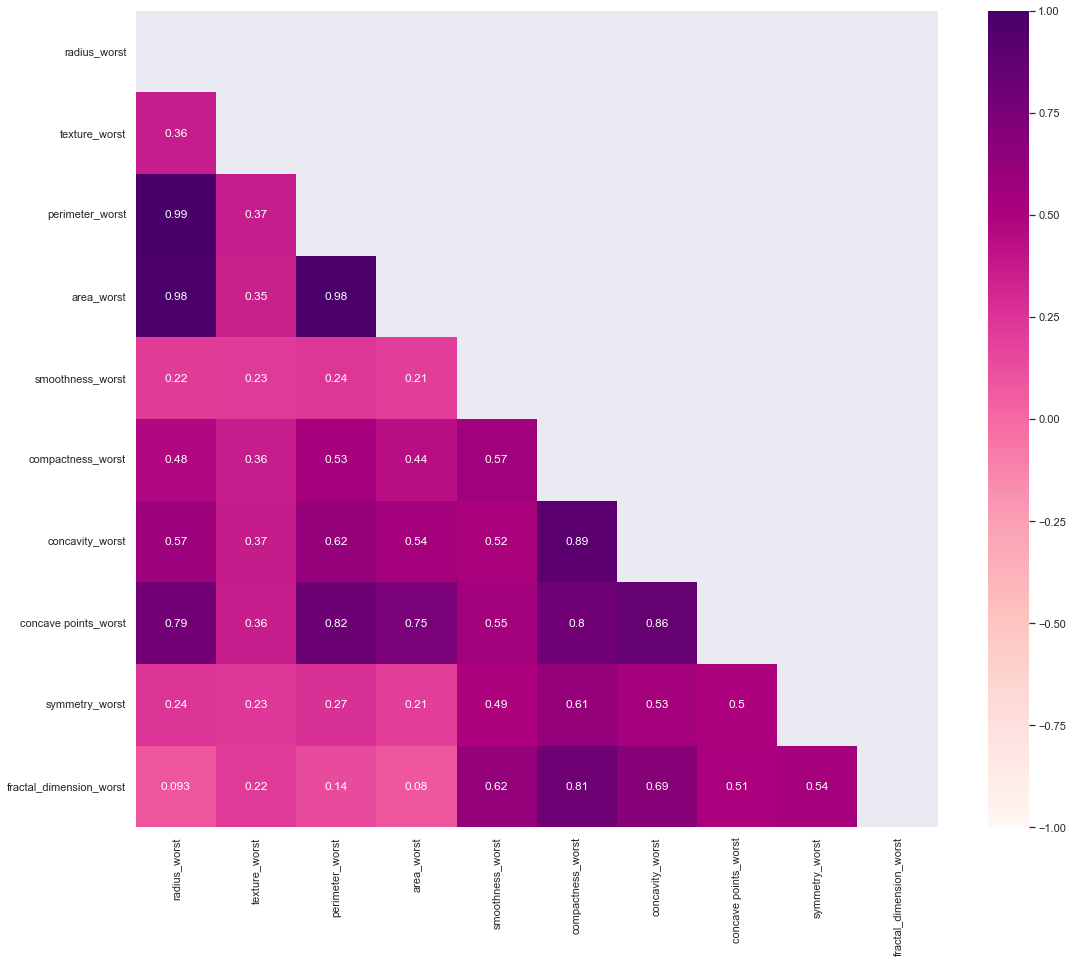

In [21]:
worst_corr = df[features_worst].corr()
plt.figure(figsize=(16, 14))
matrix = np.triu(np.ones_like(df[features_worst].corr())) # set a mask to only show lower half
sns.heatmap(worst_corr, mask=matrix, cmap='RdPu', vmin=-1, vmax=1, fmt='.2g', annot=True)

Once again, a model might only need *one of* `radius_worst`/`perimeter_worst`/`area_worst`.

Additionally, it might only need *one of* `concavity_worst`/`compactness_worst`.

With so many features as variable inputs, it's worth exploring Principal Component Analysis (PCA) to reduce dimensionality. This will potentially help with computer processing time, simplifying any relevant visualizations, and increased efficiency by dropping variables that have no effect on model accuracy. Using PCA is also a way of reducing bias in our model (when compared to *arbitrarily* choosing a threshold at which to define "worthwhile" correlations or defining levels of multicollinearity).

[↑ Back to TOC](#TOC)

**** 
<a id='Model'></a>
## 4. [Classification Modelling](#Model)

<a id='PCA'></a>
### 4a. [Principal Component Analysis (PCA)](#PCA)

In [22]:
# splitting the data
X_train, X2, y_train, y2 = train_test_split(X, y, test_size=0.3, random_state=1729)

In [23]:
# scale the data with StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X2 = scaler.transform(X2)

# employ PCA and retain only 10 dimensions
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X2 = pca.fit_transform(X2)

# the result with 10 components
print(f"After PCA, {100*sum(pca.explained_variance_ratio_)} percent of the variance is captured with 10 dimensions.")

After PCA, 95.84737795843847 percent of the variance is captured with 10 dimensions.


In [24]:
pca.explained_variance_ratio_

array([0.45442688, 0.17760225, 0.10175733, 0.06748299, 0.05451221,
       0.03937855, 0.02205298, 0.01699162, 0.01415769, 0.01011129])

Visualizing the variance in deach dimension:

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Dimension_1'),
  Text(1, 0, 'Dimension_2'),
  Text(2, 0, 'Dimension_3'),
  Text(3, 0, 'Dimension_4'),
  Text(4, 0, 'Dimension_5'),
  Text(5, 0, 'Dimension_6'),
  Text(6, 0, 'Dimension_7'),
  Text(7, 0, 'Dimension_8'),
  Text(8, 0, 'Dimension_9'),
  Text(9, 0, 'Dimension_10')])

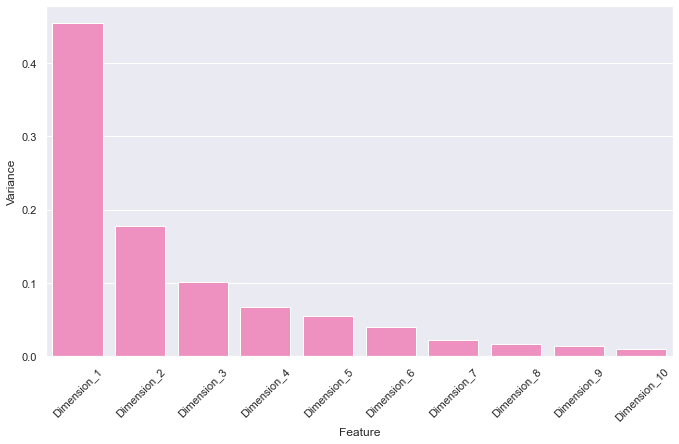

In [25]:
# converting our variance to dataframe
variance = pca.explained_variance_ratio_
variance = pd.DataFrame(variance)
# applying headers to the dataframe
variance['Feature'] = ['Dimension_1','Dimension_2','Dimension_3','Dimension_4', 'Dimension_5', 'Dimension_6', 'Dimension_7', 'Dimension_8', 'Dimension_9', 'Dimension_10']
#renaming our variance feature
variance = variance.rename(columns={0:"Variance"})

#visualing
import seaborn as sns

sns.barplot(x="Feature",y="Variance", color='xkcd:pink', data=variance)
plt.xticks(rotation=45)

We can see from the above plot that any more than 10 dimensions becomes close to negligible, in terms of variance contribution.

In [26]:
# splitting our X2 and y2 into test and validation sets of equal size (validation and test sets)
X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, random_state=1729)

In [27]:
print(f"Our training, validation, and test sets have {X_train.shape[0]}, {X_val.shape[0]}, and {X_test.shape[0]} records, respectively.")

Our training, validation, and test sets have 398, 85, and 86 records, respectively.


**** 
### Classification
Goal: To build a machine learning model that can intake various measurements of a breast cancer tumour to accurately predict whether the tumour is benign or malignant.

We will run three different classification models and compare the results of each. The four models will be
* Logistic Regession,
* Random Forest Classifier,
* Support-Vector Machine (SVM), and
* k-Nearest Neighbours (kNN)

****
<a id='LogReg'></a>
#### 4b. [Logistic Regression](#LogReg)

In [28]:
performance = []
param_set = []
params = [['newton-cg', 'lbfgs', 'sag', 'saga'], ['none', 'l2'] , (100, 10, 1.0, 0.1, 0.01)]

for hyperparameters in product(*params):
    lr_clf = LogisticRegression(solver=hyperparameters[0], penalty=hyperparameters[1],
                                 C=hyperparameters[2], random_state=1729)
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(X_val)
    performance.append(accuracy_score(y_val, y_pred))
    param_set.append(hyperparameters)

print(f'Best performance is {max(performance)}, which corresponds to hyperparameters {param_set[performance.index(max(performance))]}')

Best performance is 0.9411764705882353, which corresponds to hyperparameters ('newton-cg', 'l2', 0.1)


In [29]:
lr_clf = LogisticRegression(solver='newton-cg', penalty='l2',
                                 C=0.1, random_state=1729)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
print(f'Model accuracy estimated to be {accuracy_score(y_test, y_pred)}')

Model accuracy estimated to be 0.9651162790697675


In [30]:
# print evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        56
           1       1.00      0.90      0.95        30

    accuracy                           0.97        86
   macro avg       0.97      0.95      0.96        86
weighted avg       0.97      0.97      0.96        86



**Using Logistic Regression (LR), the model was able to correctly classify ~96.51% of tumours.**

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

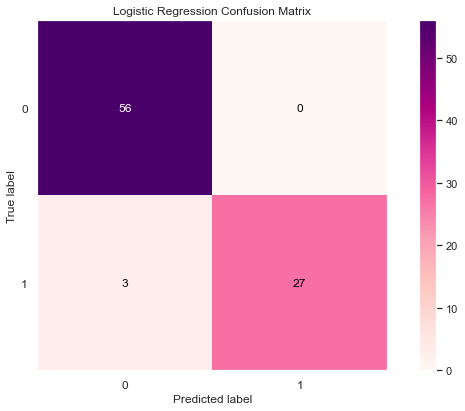

In [31]:
# visualize with a confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, cmap='RdPu')
plt.title('Logistic Regression Confusion Matrix')

****
<a id='RandFor'></a>
#### 4c. [Random Forest Classifier](#RandFor)

In [32]:
performance = []
param_set = []
params = [(5, 10, 15, 20, 25, 30, 35), (range(1,9)), (range(2,12)), (range(1,9))]

for hyperparameters in product(*params):
    clf = RandomForestClassifier(n_estimators=hyperparameters[0], max_depth=hyperparameters[1],
                                 min_samples_split=hyperparameters[2], min_samples_leaf=hyperparameters[3],
                                random_state=1729)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    performance.append(accuracy_score(y_val, y_pred))
    param_set.append(hyperparameters)

print(f'Best performance is {max(performance)}, which corresponds to hyperparameters {param_set[performance.index(max(performance))]}')

Best performance is 0.9411764705882353, which corresponds to hyperparameters (5, 5, 2, 6)


In [33]:
rf_clf = RandomForestClassifier(n_estimators=5, max_depth=5,
                             min_samples_split=2, min_samples_leaf=6,
                             random_state=1729)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(f'Model accuracy estimated to be {accuracy_score(y_test, y_pred)}')

Model accuracy estimated to be 0.9418604651162791


In [34]:
# print evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96        56
           1       0.93      0.90      0.92        30

    accuracy                           0.94        86
   macro avg       0.94      0.93      0.94        86
weighted avg       0.94      0.94      0.94        86



**A Random Forest classifier results in model accuracy of ~94.19%**.

Text(0.5, 1.0, 'RandomForest Confusion Matrix')

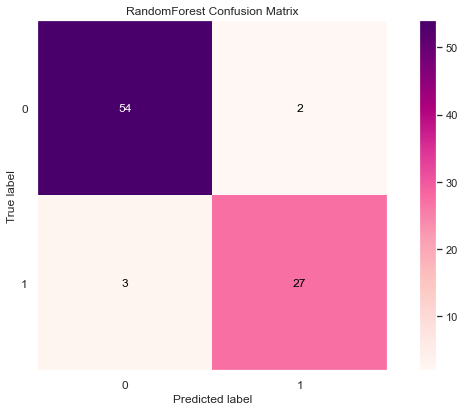

In [35]:
# visualize with a confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, cmap='RdPu')
plt.title('RandomForest Confusion Matrix')

****
<a id='SVM'></a>
#### 4d. [Support Vector Machine (SVM)](#SVM)

In [36]:
performance = []
param_set = []
params = [['linear', 'poly', 'rbf', 'sigmoid'], (100, 10, 1.0, 0.1, 0.01), ['scale', 'auto']]

for hyperparameters in product(*params):
    clf = SVC(kernel=hyperparameters[0], C=hyperparameters[1], gamma=hyperparameters[2], random_state=1729)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    performance.append(accuracy_score(y_val, y_pred))
    param_set.append(hyperparameters)

print(f'Best performance is {max(performance)}, which corresponds to hyperparameters {param_set[performance.index(max(performance))]}')

Best performance is 0.9529411764705882, which corresponds to hyperparameters ('poly', 1.0, 'auto')


In [37]:
svm_clf = SVC(kernel='poly', C=1.0, gamma='auto', random_state=1729)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print(f'Model accuracy estimated to be {accuracy_score(y_test, y_pred)}')

Model accuracy estimated to be 0.9651162790697675


In [38]:
# print evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        56
           1       0.97      0.93      0.95        30

    accuracy                           0.97        86
   macro avg       0.97      0.96      0.96        86
weighted avg       0.97      0.97      0.96        86



**With an SVM, ~96.51% of tumours were classified correctly.**

Text(0.5, 1.0, 'SVM Confusion Matrix')

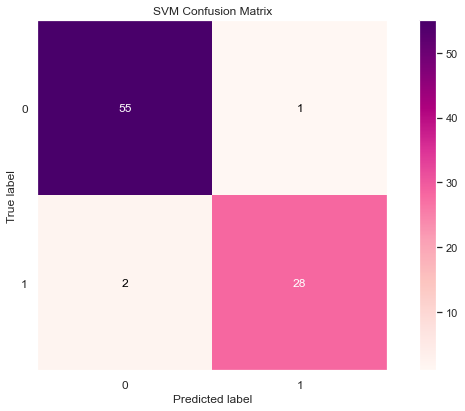

In [39]:
# visualize with a confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, cmap='RdPu')
plt.title('SVM Confusion Matrix')

****
<a id='kNN'></a>
#### 4e. [k-Nearest Neighbours (kNN)](#kNN)

In [40]:
performance = []
param_set = []
params = [(range(1,21)), ['euclidean', 'manhattan', 'minkowski'], ['uniform', 'distance']]

for hyperparameters in product(*params):
    clf = KNeighborsClassifier(n_neighbors=hyperparameters[0], metric=hyperparameters[1], weights=hyperparameters[2])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    performance.append(accuracy_score(y_val, y_pred))
    param_set.append(hyperparameters)

print(f'Best performance is {max(performance)}, which corresponds to hyperparameters {param_set[performance.index(max(performance))]}')

Best performance is 0.9647058823529412, which corresponds to hyperparameters (1, 'euclidean', 'uniform')


In [41]:
knn_clf = KNeighborsClassifier(n_neighbors=1, metric='euclidean', weights='uniform')
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
print(f'Model accuracy estimated to be {accuracy_score(y_test, y_pred)}')

Model accuracy estimated to be 0.9534883720930233


In [42]:
# print evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        56
           1       0.96      0.90      0.93        30

    accuracy                           0.95        86
   macro avg       0.96      0.94      0.95        86
weighted avg       0.95      0.95      0.95        86



**Finally, using k-Nearest Neighbours, the model is ~95.35% accurate**.

Text(0.5, 1.0, 'kNN Confusion Matrix')

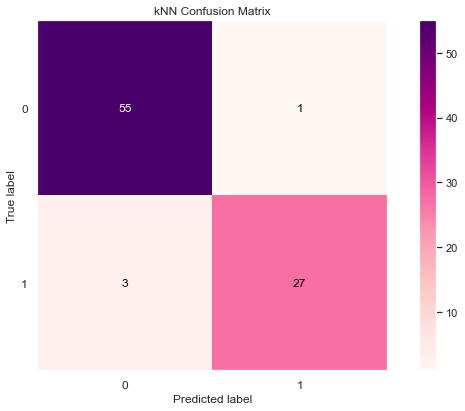

In [43]:
# visualize with a confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, cmap='RdPu')
plt.title('kNN Confusion Matrix')

[↑ Back to TOC](#TOC)

**** 
<a id='Conclusions'></a>
## 5. [Conclusions](#Conclusions)

<a id='Summary'></a>
### 5a. [Summary](#Summary)

The test set included 86 records, of which 56 were benign and 30 were malignant (roughly a 65/35 split). This composition ratio is approximately equal to that of the original dataset (357 benign and 212 malignant, roughly a 63/37 split).

#### **Accuracy Recap:**
* ***Logisitic Regression (LR): 96.51%***
* ***SVM: 96.51%***
* *kNN: 95.35%*
* *Random Forest: 94.19%*


Based on the above models and their respective performances, **LR and SVM seem to be more accurate than kNN or Random Forest**.

That said, most patients would likely appreciate an accuracy rate even higher than 96% for medical diagnosis. This is elaborated on further in the "*Ethical Notes*" section below.

****
<a id='Ethics'></a>
### 5b. [Ethical Notes](#Ethics)

Perhaps most importantly, it should be noted that **the results of this analysis should not be interpreted as bonafide diagnostic medical advice**. With such a small dataset on which to draw conclusions, results should be taken with a grain of salt. That said, there should be a sense of optimism when looking at these models, appreciating, if anything, that this is a strong foundation on which to build with more data.


#### <ins>Errors</ins>
* **Type I (*false positive*) errors** are counted in the upper right of each of the confusion matrices above, representing instances of a tumour being classified as malignant when it is, in fact, benign. These errors can potentially lead to an individual unnecessarily receiving invasive treatment or undergoing heavy radiation, presenting a host of avoidable risks. The count of false positives for LR and SVM are 0 and 1, respectively. On this basis alone, one might tend to prefer Logistic Regression.

* **Type II (*false negative*) errors** are counted in the bottom left of each of the confusion matrices above, representing instances of a tumour being *falsely* classified as benign. These misdiagnoses are concerning in their own right, as treatment options and other necessary medical supports would, hypothetically, not be offered with the same degree of urgency as an accurately-labelled malignant case. The count of false negatives for LR and SVM are 3 and 2, respectively. On *this* basis alone, one might tend to prefer SVM.

Of course, the two *tendencies* mentioned above are in conflict with one another (to be expected, since they both exhibit the same percent accuracy). Misdiagnoses of any ilk are concerning, so it would be unfair to favour one of these models over the other (at least, as an individual outside of the world medical diagnostics). Another demonstration of the need for more data to further train the models across a wider array of cases.

****
<a id='Recommendations'></a>
### 5c. [Recommendations/Areas for Further Exploration](#Recommendations)

* **More data** - As mentioned already, in order to increase robustness of the findings from this analysis, far more data is required. While the results here are promising, it would be prudent to treat these an preliminary findings in need of greater support.
* **PCA vs. manual** - While there were initial glances at feature selection in the EDA of this analysis, we ended up opting for PCA to reduce dimensionality. It would be worthwhile to set critera in order to choose certain features "manually", partition new training/validation/test sets, and observe the resulting accuracy in comparison to PCA.
* **Cross-validation** - Cross-validation (or "k-Fold Cross-Validation") is a statistical method by which the training set is "reshuffled" to include different records over *k* iterations. This procedure is especially helpful for smaller and imbalanced datasets (both of which describe this dataset, coincidentally) and would be worth exploring in subsequent analyses.
* **Hyperparameters** - Though there was a degree of hyperparameter tuning done in the building of each model, not *all* parameters of each model were experimented with. There could be benefit in adjusting less/more/different hyperparameters, while also mitigating and unwanted bias in the model. Suggestions for which parameters to tune are partially credited to [Dr. J. Brownlee, PhD](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/).

****
**For more information on the state of breast cancer in Canada (as of 2021), check out the associated [Breast Cancer Dashboard](https://public.tableau.com/views/Breast_Cancer_Dashboard/BreastCancerDashboard?:language=en-US&:display_count=n&:origin=viz_share_link) on *Tableau Public*.**
**** 

[↑ Back to TOC](#TOC)

~ *fin* ~